In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pickle
import gc

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from torch.nn.utils.rnn import pad_sequence
from torch.nn.utils.rnn import pad_packed_sequence
from torch.nn.utils.rnn import pack_padded_sequence

## Global settings

In [2]:
print('Torch version: {}'.format(torch.__version__))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device: %s' % (device))

Torch version: 1.0.0
Device: cpu


## Load data

In [3]:
features = pickle.load(open('../data/pickle/ballroom_features_boeck.npy', 'rb'))

labels = pickle.load(open('../data/pickle/ballroom_labels_boeck.npy', 'rb'))

## Create 'Dataset' and 'DataLoader' 

In [4]:
class Data(Dataset):
    def __init__(self):
        pass
        
    def __getitem__(self, index): 
        return features[index], labels[index]
        
    def __len__(self):
        return len(features)
    
# merges a list of samples to form a mini-batch
def collate_fn(batch):
    features, labels = zip(*batch)
    
    features = pad_sequence(features, batch_first=True)
    
    labels = pad_sequence(labels, batch_first=True)
    
    return features, labels

In [5]:
dataset = Data()

len_dataset = len(dataset)
nr_folds = 8 

len_test = int((1 / nr_folds) * len_dataset)
len_train = len_dataset - len_test

# Random split
np.random.seed(0)
perm = np.random.permutation(len_dataset)

## Select Fold

In [6]:
fold = 0

indices_test = perm[len_test*fold:len_test*(fold+1)]
indices_train = np.delete(perm, np.arange(len_test*fold,len_test*(fold+1)))

In [7]:
batch_size = 10 

trainset = Subset(dataset=dataset, indices=indices_train)
testset = Subset(dataset=dataset, indices=indices_test)

trainloader = DataLoader(dataset=trainset, batch_size=batch_size, drop_last=True, collate_fn=collate_fn)
testloader = DataLoader(dataset=testset, batch_size=batch_size, drop_last=True, collate_fn=collate_fn)

## Model

In [8]:
class ModelBoeck(nn.Module):
    def __init__(self):
        super(ModelBoeck, self).__init__()
        
        # Model parameters
        self.input_size = 120
        self.output_size = 2
        self.num_layers = 3
        self.hidden_size = 25     
        self.bidirectional = True
        self.num_directions = 2 if self.bidirectional else 1
        
        # Recurrent layer 
        self.lstm = nn.LSTM(input_size=self.input_size, 
                            hidden_size=self.hidden_size, 
                            num_layers=self.num_layers, 
                            bidirectional=self.bidirectional,
                            batch_first=True)
        
        # Read out layer
        self.fc = nn.Linear(self.num_directions * self.hidden_size, self.output_size)       
        
    def forward(self, x): 
        
#         packed = pack_padded_sequence(x, lengths, batch_first=True)
        
        lstm_out, _ = self.lstm(x) 
        
#         lstm_out, _ = pad_packed_sequence(lstm_out, batch_first=True)
        
        fc_out = self.fc(lstm_out)
        
        y = F.log_softmax(fc_out, dim=2)
        
        return torch.transpose(y, 1, 2)

In [9]:
model = ModelBoeck().to(device)

loss_vec = []

In [10]:
loss_function = nn.NLLLoss(weight=torch.tensor([1., 70.]).to(device))

optimizer = optim.Adam(model.parameters(), lr=1e-4, betas=(0.9, 0.999), eps=1e-08)

## Load trained parameters

In [11]:
model.load_state_dict(torch.load('../models/model_boeck.pt'))

## Train the model 

In [12]:
for epoch in range(2):  
    for i, (feature, label) in enumerate(trainloader):
        
        # Clear out accumulates gradients 
        model.zero_grad()

        # Forward pass
        out = model(feature.to(device))

        # Backward propagation
        loss = loss_function(out, label.to(device))
        loss_vec.append(loss)

        # Calculate gradients
        loss.backward()

        # Optimization 
        optimizer.step()

        print('Epoch: {:2d}   Batch: {:2d} of {:d}   Loss: {:.3e}'
              .format(epoch+1, i+1, len(trainloader), loss.item()))
        del feature, label, out
    gc.collect()

Epoch:  1   Batch:  1 of 61   Loss: 4.254e-01
Epoch:  1   Batch:  2 of 61   Loss: 4.104e-01
Epoch:  1   Batch:  3 of 61   Loss: 4.066e-01
Epoch:  1   Batch:  4 of 61   Loss: 4.622e-01
Epoch:  1   Batch:  5 of 61   Loss: 3.913e-01
Epoch:  1   Batch:  6 of 61   Loss: 4.356e-01
Epoch:  1   Batch:  7 of 61   Loss: 4.194e-01
Epoch:  1   Batch:  8 of 61   Loss: 4.030e-01
Epoch:  1   Batch:  9 of 61   Loss: 3.684e-01
Epoch:  1   Batch: 10 of 61   Loss: 3.617e-01
Epoch:  1   Batch: 11 of 61   Loss: 3.977e-01
Epoch:  1   Batch: 12 of 61   Loss: 4.221e-01
Epoch:  1   Batch: 13 of 61   Loss: 4.579e-01
Epoch:  1   Batch: 14 of 61   Loss: 4.431e-01
Epoch:  1   Batch: 15 of 61   Loss: 4.687e-01
Epoch:  1   Batch: 16 of 61   Loss: 4.334e-01
Epoch:  1   Batch: 17 of 61   Loss: 4.056e-01
Epoch:  1   Batch: 18 of 61   Loss: 3.827e-01
Epoch:  1   Batch: 19 of 61   Loss: 4.090e-01
Epoch:  1   Batch: 20 of 61   Loss: 4.109e-01
Epoch:  1   Batch: 21 of 61   Loss: 4.251e-01
Epoch:  1   Batch: 22 of 61   Loss

## Plot loss

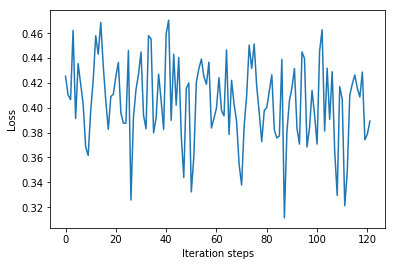

In [13]:
plt.plot(loss_vec);
plt.xlabel('Iteration steps');
plt.ylabel('Loss');
# plt.savefig("test.eps");

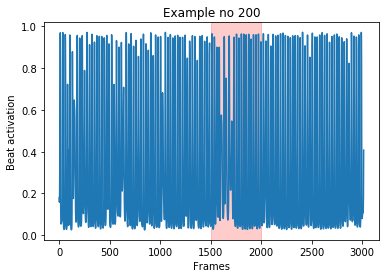

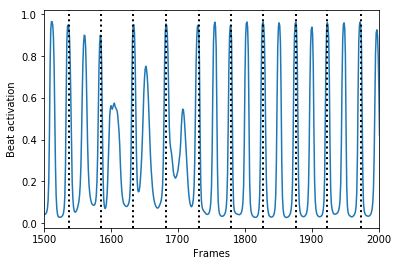

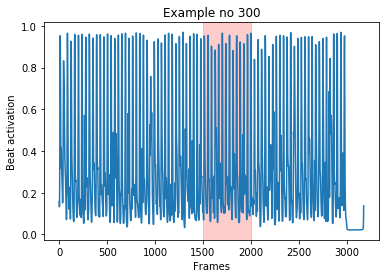

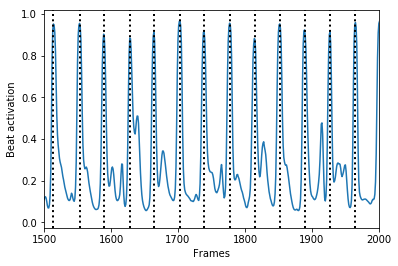

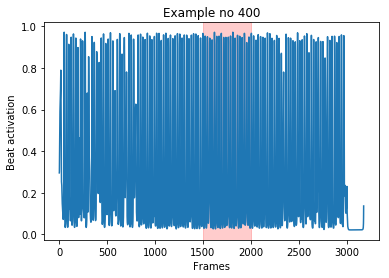

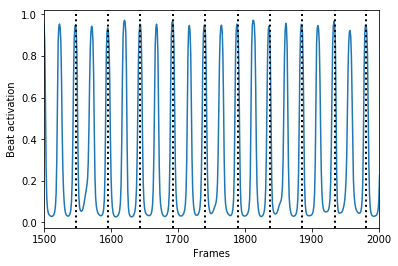

In [14]:
examples = [200, 300, 400]

for example in examples:

    test_input = features[example].view(1, len(features[example]),-1)
    test_label = labels[example]

    with torch.no_grad():
        out = model(test_input)

    activation = np.exp(np.array(out[0,1,:]))

    zoom = (1500, 2000)

    plt.figure()
    plt.plot(activation)
    plt.xlabel('Frames')
    plt.ylabel('Beat activation')
    plt.axvspan(zoom[0], zoom[1], alpha=0.2, color='red')
    plt.title('Example no {}'.format(example))


    plt.figure()   
    plt.plot(activation)
    plt.xlabel('Frames')
    plt.ylabel('Beat activation')
    for beat in np.where(test_label == 1.0)[0]:
        plt.axvline(x=beat, color='k', linestyle=':', linewidth=2)
    plt.xlim(zoom);

## Save model parameters

In [15]:
torch.save(model.state_dict(), '../models/model_boeck.pt')

## Appendix

In [16]:
num_beats = np.sum(np.array(test_label))
length = len(np.array(test_label))
length / num_beats

50.46031746031746

In [17]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

num_param = count_parameters(model)

print('Number of learnable Parameters: %d' % (num_param))

Number of learnable Parameters: 60302


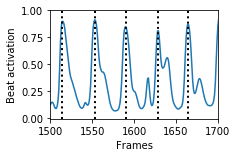

In [18]:
examples = [300]

for example in examples:

    test_input = features[example].view(1, len(features[example]),-1)
    test_label = labels[example]

    with torch.no_grad():
        out = model(test_input)

    activation = np.exp(np.array(out[0,1,:]))

    zoom = (1500, 1700)

    plt.figure(figsize=(3,2))   
    plt.plot(activation)
    plt.xlabel('Frames')
    plt.ylabel('Beat activation')
    for beat in np.where(test_label == 1.0)[0]:
        plt.axvline(x=beat, color='k', linestyle=':', linewidth=2)
    plt.xlim(zoom);

plt.savefig('beat_activation.png')

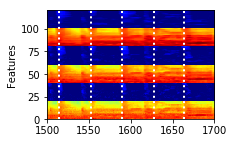

In [19]:
plt.figure(figsize=(3,2))

plt.imshow(np.array(features[300]).T[:,zoom[0]:zoom[1]], 
           extent=(zoom[0], zoom[1], 0.5, 120+0.5),
           origin='lower', aspect='auto',cmap='jet');
# plt.yticks(np.arange(1,20,2));
# plt.ylim(0.5,num_bands+0.5)

# plt.colorbar(format='%.1f');

plt.ylabel('Features');

for beat in np.where(test_label == 1.0)[0]:
    plt.axvline(x=beat, color='w', linestyle=':', linewidth=2)
plt.xlim(zoom);

plt.savefig('feature_vector.png')

In [20]:
files = sorted(os.listdir('../data/audio/Ballroom/'))

_, signal = wavfile.read('../data/audio/Ballroom/' + files[300], mmap=False) # is mmap=True necessary ? 

/Users/juliusrichter/anaconda3/lib/python3.6/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


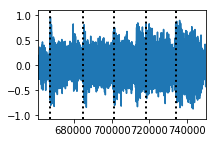

In [21]:
sr = 44.1e3
plt.figure(figsize=(3,2))
plt.plot(signal/np.max(signal));
plt.xlim((sr*15, sr*17));

for beat in np.where(test_label == 1.0)[0]:
    plt.axvline(x=beat*441, color='k', linestyle=':', linewidth=2)
    
plt.savefig('audio_snippet.eps')
plt.savefig('audio_snippet.png')